In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../../Data/Processed/Climate_data.csv')

IRS_data = pd.read_csv('../../Data/Processed/time_features_cleaned.csv')

In [3]:
data.head()

IRS_data.head()

,Unnamed_0,date,meantemp,humidity,wind_speed,meanpressure,month,year,sin_dayofyear,cos_dayofyear,...,meantemp_roll_mean_7d,meantemp_roll_mean_30d,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7
0,0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,2013,0.017166,0.999853,...,NaN,NaN,1,0,0,0,0,0,0,0
1,1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,1,2013,0.034328,0.999411,...,10.000000,10.000000,1,0,0,0,0,0,0,0
2,2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,1,2013,0.051479,0.998674,...,8.700000,8.700000,1,0,0,0,0,0,0,0
3,3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,1,2013,0.068615,0.997643,...,8.188889,8.188889,1,0,0,0,0,0,0,0
4,4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,1,2013,0.085731,0.996318,...,8.308333,8.308333,1,0,0,0,0,0,0,0


In [4]:
data

,date,meantemp,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
0,2013-01-01,0.122271,0.840372,0.000000,0.132603,0.0,0.000000,0.000000,0.166667
1,2013-01-02,0.042795,0.929054,0.070583,0.132881,0.0,0.000000,0.033333,0.333333
2,2013-01-03,0.035662,0.869932,0.109743,0.132994,0.0,0.000000,0.066667,0.500000
3,2013-01-04,0.081514,0.684685,0.029212,0.132799,0.0,0.000000,0.100000,0.666667
4,2013-01-05,0.000000,0.867962,0.087636,0.132712,0.0,0.000000,0.133333,0.833333
...,...,...,...,...,...,...,...,...,...
1570,2017-04-20,0.871179,0.166385,0.131750,0.130385,1.0,0.272727,0.633333,0.500000
1571,2017-04-21,0.863537,0.306799,0.164910,0.130548,1.0,0.272727,0.666667,0.666667
1572,2017-04-22,0.822271,0.324831,0.210564,0.130772,1.0,0.272727,0.700000,0.833333
1573,2017-04-23,0.821507,0.166385,0.235966,0.130841,1.0,0.272727,0.733333,1.000000


In [5]:
train = data[:-180]
test = data[-180:]
print(train.shape)
print(test.shape)

IRS_train = IRS_data[:-180]
IRS_test = IRS_data[-180:]

print(IRS_train.shape)
print(IRS_test.shape)

IRS_train.tail()

(1395, 9)
(180, 9)
(1395, 21)
(180, 21)


,Unnamed_0,date,meantemp,humidity,wind_speed,meanpressure,month,year,sin_dayofyear,cos_dayofyear,...,meantemp_roll_mean_7d,meantemp_roll_mean_30d,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7
1390,1390,2016-10-22,29.333333,49.481481,13.323077,1009.370370,10,2016,-0.932655,0.360771,...,28.525893,30.452087,0,0,0,0,0,0,0,1
1391,1391,2016-10-23,27.500000,54.961538,11.546154,1009.307692,10,2016,-0.926324,0.376728,...,28.753406,30.428630,0,0,0,0,0,0,0,1
1392,1392,2016-10-24,28.500000,51.423077,11.188462,1008.269231,10,2016,-0.919720,0.392574,...,28.620753,30.311963,0,0,0,0,0,0,0,1
1393,1393,2016-10-25,28.040000,54.560000,12.388462,1008.923077,10,2016,-0.912846,0.408304,...,28.606468,30.220630,0,0,0,0,0,0,0,1
1394,1394,2016-10-26,27.576923,56.192308,5.700000,1011.730769,10,2016,-0.905702,0.423914,...,28.540753,30.117616,0,0,0,0,0,0,0,1


In [6]:
x_train = train.drop(columns = {'date','meantemp'}, axis = 1)
y_train = train.loc[:, ['meantemp']]


IRS_x_train = IRS_train.drop(columns = {'date','meantemp'}, axis = 1)
IRS_y_train = IRS_train.loc[:, ['meantemp']]

x_test = test.drop(columns = {'date','meantemp'}, axis = 1)
y_test = test.loc[:, ['meantemp']]

IRS_x_test = IRS_test.drop(columns = {'date','meantemp'}, axis = 1)
IRS_y_test = IRS_test.loc[:, ['meantemp']]

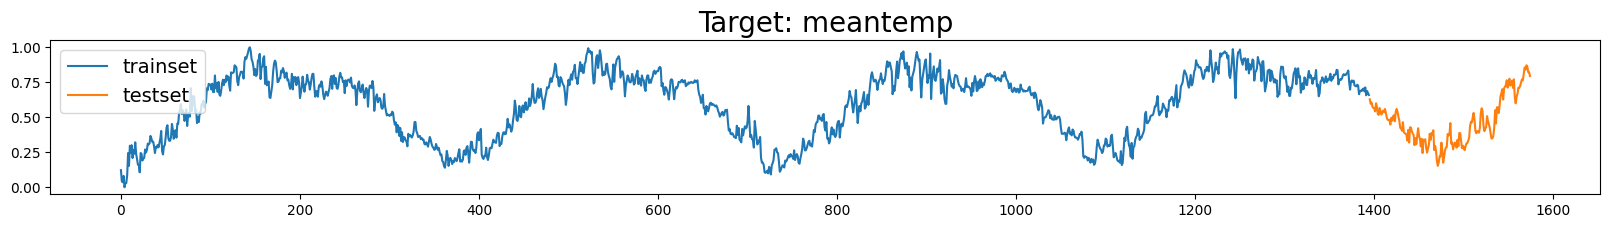

In [7]:
sns.reset_orig()
plt.figure(figsize = (20,2))
plt.title('Target: meantemp', fontsize = 20)
plt.plot(y_train['meantemp'], label = 'trainset')
plt.plot(y_test['meantemp'], label = 'testset')

plt.legend(fontsize = 14)
plt.show()

# LightGBM

In [8]:
import lightgbm as lgb

In [9]:
# train the lightGBM model
model = lgb.LGBMRegressor().fit(x_train, y_train)

pred = model.predict(x_test)

# R^2
r2 = r2_score(pred, y_test)
mse = mean_squared_error(pred, y_test)
print('R2: ', r2, '  ;  ', 'MSE: ', mse)

IRS_model = lgb.LGBMRegressor().fit(IRS_x_train, IRS_y_train)

IRS_pred = IRS_model.predict(IRS_x_test)
IRS_r2 = r2_score(IRS_pred, IRS_y_test)
IRS_mse = mean_squared_error(IRS_pred, IRS_y_test)
print('R2: ', IRS_r2, '  ;  ', 'MSE: ', IRS_mse)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 7
[LightGBM] [Info] Start training from score 0.603260
R2:  0.7814408856481162   ;   MSE:  0.008271250694535643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 18
[LightGBM] [Info] Start training from score 25.735216
R2:  0.926249900902019   ;   MSE:  2.2558803201923006


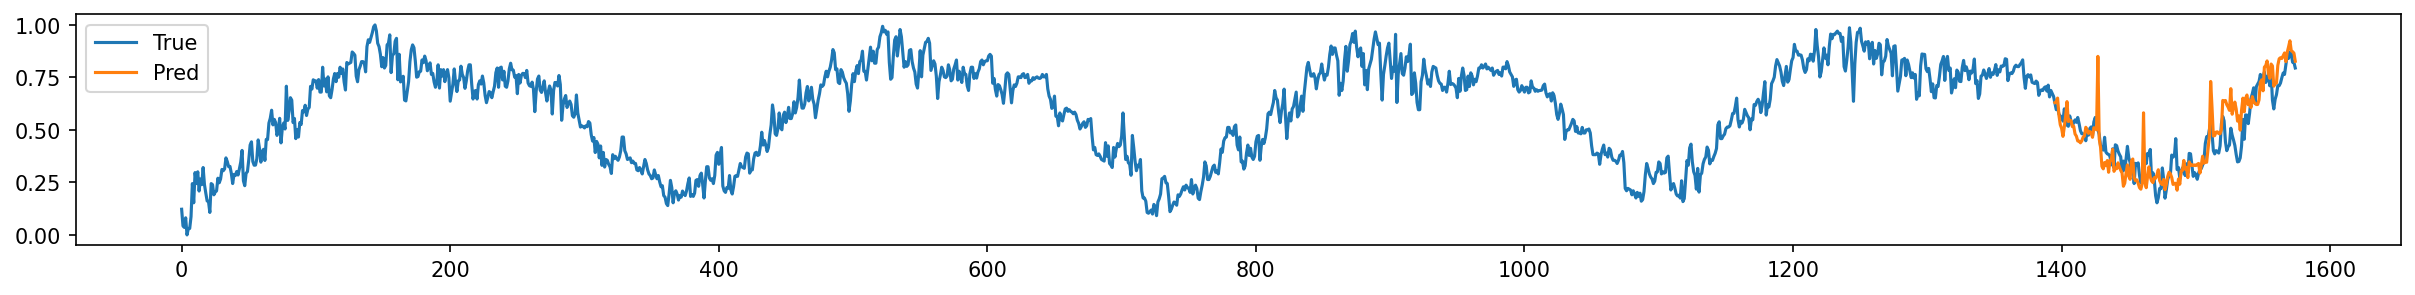

In [10]:
prediction = pd.DataFrame(pred, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,2), dpi=150)

plt.plot(data['meantemp'], label = 'True')
plt.plot(prediction, label = 'Pred')

plt.legend()

plt.show()

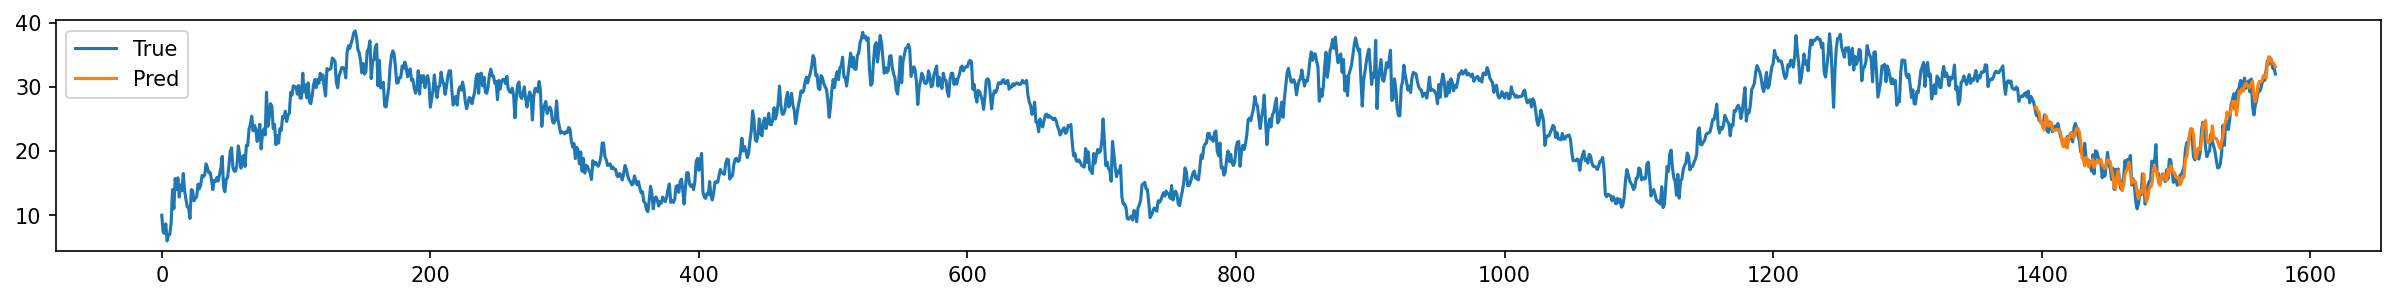

In [11]:
IRS_prediction = pd.DataFrame(IRS_pred, index=IRS_y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,2), dpi=150)

plt.plot(IRS_data['meantemp'], label = 'True')
plt.plot(IRS_prediction, label = 'Pred')

plt.legend()

plt.show()

# Interpretation of LightGBM

In [12]:
import ShapTimeBoosting
from ShapTimeBoosting import supertime, ShapleyValues, TimeImportance, TimeHeatmap

In [13]:
# The training set is evenly divided into 8 parts in the time dimension, 
# and the importance of each part is calculated.
Tn= 8

interp_x= x_train
IRS_interp_x = IRS_x_train
model = model

IRS_model = IRS_model

# a list of 8 Shapley values per SHAPTime definition
# one for each time chunk out of 8
ShapTime_lgb = ShapleyValues(model, interp_x, Tn)



In [14]:
ShapTime_lgb

[np.float64(-0.012461220892220334),
 np.float64(0.003985234530871604),
 np.float64(-0.041053474239185615),
 np.float64(0.03391227164457228),
 np.float64(-0.05451358583048289),
 np.float64(0.046430979020581936),
 np.float64(-0.0464967784101408),
 np.float64(0.0712799978148201)]

In [15]:
# name these time periods
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7']

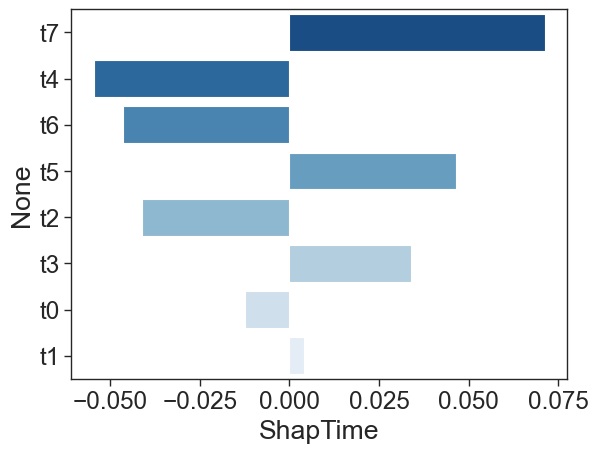

In [16]:
# Time importance is just the author-defined 
# code that provides this plot
TimeImportance(Tn, ShapTime_lgb, time_columns)

In [17]:
# PHASE Two

import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def TimeIntervalSHAP(model, x_data, interval_features):
    """
    Compute SHAP values for binary time-interval indicator features (T_1,...,T_8).
    
    Parameters
    ----------
    model : trained LightGBM model
    x_data : pd.DataFrame with ALL model input features including T_1...T_8
    interval_features : list of columns corresponding to interval indicators
    
    Returns
    -------
    shap_interval_df : DataFrame with SHAP value for each interval (signed)
    """
    
    # 1️⃣ Compute SHAP values for ALL features (LightGBM requires full feature set)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_data)
    
    # Convert to DataFrame
    shap_df = pd.DataFrame(shap_values, columns=x_data.columns)
    
    # 2️⃣ Keep only the interval feature SHAP values
    shap_interval = shap_df[interval_features]
    
    # 3️⃣ Average the SHAP value for each interval across all rows
    interval_means = shap_interval.mean(axis=0)
    
    # Build output DataFrame
    shap_interval_df = pd.DataFrame({
        "ShapleyValue": interval_means,
        "absolute": interval_means.abs()
    })
    
    # Sort by absolute value like SHAPTime
    shap_interval_df.sort_values(by="absolute", ascending=False, inplace=True)
    
    # 4️⃣ Plot (same style as SHAPTime)
    sns.set(context='paper', style='ticks', font_scale=2)
    ax = sns.barplot(
        x="ShapleyValue",
        y=shap_interval_df.index,
        data=shap_interval_df,
        orient="h",
        color="lightskyblue",
        palette="Blues_r"
    )
    ax.set_xlabel("Shapley Value (Interval Feature Importance)")
    ax.set_ylabel("Time Interval")
    plt.show()
    
    return shap_interval_df


In [18]:
IRS_x_train[IRS_x_train['t_7'] == 1]

,Unnamed_0,humidity,wind_speed,meanpressure,month,year,sin_dayofyear,cos_dayofyear,meantemp_lag_1,meantemp_roll_mean_7d,meantemp_roll_mean_30d,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7
1378,1378,51.111111,4.807407,1006.148148,10,2016,-0.986731,0.162366,30.920000,30.834546,31.642701,0,0,0,0,0,0,0,1
1379,1379,51.148148,8.922222,1006.592593,10,2016,-0.983798,0.179281,29.777778,30.335767,31.594268,0,0,0,0,0,0,0,1
1380,1380,47.285714,11.371429,1006.250000,10,2016,-0.980575,0.196143,29.666667,30.208783,31.549824,0,0,0,0,0,0,0,1
1381,1381,44.000000,13.022222,1008.333333,10,2016,-0.977064,0.212947,29.571429,30.314225,31.480776,0,0,0,0,0,0,0,1
1382,1382,47.875000,8.934783,1009.125000,10,2016,-0.973264,0.229688,29.962963,30.208405,31.395097,0,0,0,0,0,0,0,1
1383,1383,54.148148,6.662963,1010.518519,10,2016,-0.969178,0.246361,29.750000,30.035548,31.358192,0,0,0,0,0,0,0,1
1384,1384,49.857143,7.014286,1011.857143,10,2016,-0.964806,0.262962,27.740741,29.627082,31.225308,0,0,0,0,0,0,0,1
1385,1385,49.240000,7.116000,1010.560000,10,2016,-0.960150,0.279486,28.428571,29.271164,31.126260,0,0,0,0,0,0,0,1
1386,1386,48.458333,7.668182,1009.458333,10,2016,-0.955211,0.295927,28.600000,29.102910,31.002670,0,0,0,0,0,0,0,1
1387,1387,49.185185,6.459259,1008.555556,10,2016,-0.949990,0.312281,28.500000,28.936243,30.877670,0,0,0,0,0,0,0,1


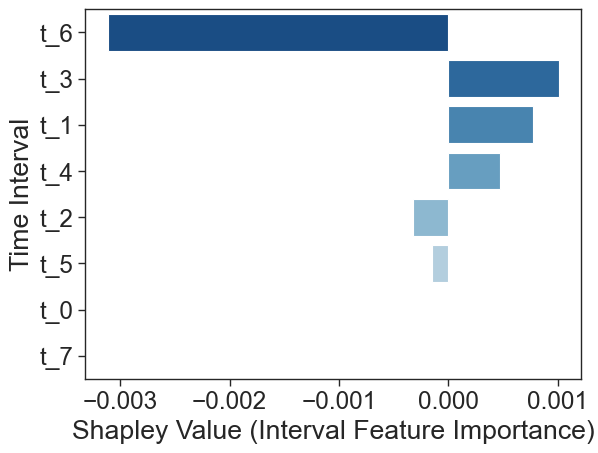

In [19]:
interval_features = ["t_0","t_1","t_2","t_3","t_4","t_5","t_6","t_7"]

shap_interval_vals = TimeIntervalSHAP(
    IRS_model,
    IRS_x_train,   # dataset used to train the model
    interval_features
)

# negative value => as this goes up, prediction meantemp goes down


In [20]:
# IGNORE

In [21]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import shap

# # OUR TIME ENCODED DATA 
# def TimeImportanceEncoded(model, x_data, time_features, time_columns, Tn=8, time_column=None):
#     """
#     Compute and plot temporal importance using standard SHAP values
#     for only time-related features, aggregated over Tn intervals,
#     keeping the sign (positive/negative) to mirror SHAPTime plot.

#     Parameters
#     ----------
#     model : trained LightGBM model
#     x_data : pd.DataFrame, includes all features used for prediction
#     time_features : list of column names that encode temporal info
#     time_columns : list of names for the time intervals (length Tn)
#     Tn : int, number of time intervals to split
#     time_column : str, optional, column representing time for grouping rows
#     """
    
#     x_data = x_data.copy()
    
#     # 1️⃣ Create time intervals
#     n = len(x_data)
#     if time_column is None:
#         x_data['time_group'] = pd.qcut(range(n), q=Tn, labels=False)
#     else:
#         x_data['time_group'] = pd.qcut(x_data[time_column], q=Tn, labels=False)
    
#     # 2️⃣ Compute SHAP values for all features
#     feature_cols = [c for c in x_data.columns if c != 'time_group']
#     explainer = shap.TreeExplainer(model)
#     shap_values_all = explainer.shap_values(x_data[feature_cols])
    
#     # Convert to DataFrame
#     shap_df_all = pd.DataFrame(shap_values_all, columns=feature_cols)
    
#     # 3️⃣ Keep only time-related features for aggregation
#     shap_df_time = shap_df_all[time_features].copy()
#     shap_df_time['time_group'] = x_data['time_group']
    
#     # 4️⃣ Aggregate SHAP values per time interval, keeping sign
#     interval_importance = shap_df_time.groupby('time_group').mean().mean(axis=1)
    
#     # 5️⃣ Prepare DataFrame for plotting
#     plot_df = pd.DataFrame({'ShapTime': interval_importance.values})
    
#     # Assign user-provided interval names
#     if len(time_columns) != Tn:
#         raise ValueError("Length of time_columns must equal Tn")
#     plot_df.index = time_columns
    
#     # Sort by ShapTime (optional)
#     plot_df.sort_values(by='ShapTime', inplace=True)
    
#     # 6️⃣ Plot (horizontal barplot, signed)
#     sns.set(context='paper', style='ticks', font_scale=2)
#     ax = sns.barplot(
#         x="ShapTime",
#         y=plot_df.index,
#         data=plot_df,
#         orient='h',
#         color="lightskyblue",
#         palette='Blues_r'
#     )
#     ax.set_xlabel("SHAP Value (Temporal Importance)")
#     ax.set_ylabel("Time Interval")
#     plt.show()
    
#     return plot_df


In [22]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import shap

# # NOT INTENDED FOR TIME ENCODED DATA

# def TimeImportanceTraditionalSHAP(model, x_data, time_columns, Tn=8, time_column=None):
#     """
#     Compute and plot temporal importance using traditional SHAP
#     for the SAME model used with SHAPTime (no time-encoded features),
#     by aggregating feature-level SHAP values over Tn time intervals.

#     Parameters
#     ----------
#     model : trained LightGBM model (same one used for SHAPTime)
#     x_data : pd.DataFrame, features used to train that model
#     time_columns : list of names for the time intervals (length Tn)
#     Tn : int, number of time intervals to split
#     time_column : str, optional, column representing time for grouping rows
#                   If None, row order is used.
#     """

#     x_data = x_data.copy()

#     # 1️⃣ Create time intervals (same idea as SHAPTime)
#     n = len(x_data)
#     if time_column is None:
#         x_data['time_group'] = pd.qcut(range(n), q=Tn, labels=False)
#     else:
#         x_data['time_group'] = pd.qcut(x_data[time_column], q=Tn, labels=False)

#     # 2️⃣ Compute traditional SHAP values for ALL features
#     #    (must match training features exactly)
#     feature_cols = [c for c in x_data.columns if c != 'time_group']
#     explainer = shap.TreeExplainer(model)
#     shap_values_all = explainer.shap_values(x_data[feature_cols])

#     # Put SHAP values in a DataFrame
#     shap_df_all = pd.DataFrame(shap_values_all, columns=feature_cols)
#     shap_df_all['time_group'] = x_data['time_group']

#     # 3️⃣ Aggregate SHAP per time interval (keep sign)
#     #    → mean over rows in interval, then mean over features
#     interval_importance = (
#         shap_df_all
#         .groupby('time_group')
#         .mean()           # avg SHAP per feature in each interval
#         .mean(axis=1)     # avg across all features
#     )

#     # 4️⃣ Build DataFrame in the same style as original TimeImportance
#     if len(time_columns) != Tn:
#         raise ValueError("Length of time_columns must equal Tn")

#     shapley_impor = pd.DataFrame(index=range(Tn), columns=['ShapTime'])
#     shapley_impor['ShapTime'] = interval_importance.values
#     shapley_impor['absolute'] = shapley_impor['ShapTime'].abs()

#     # Set readable interval labels
#     shapley_impor.index = time_columns

#     # Sort by absolute magnitude (like original SHAPTime plot)
#     shapley_impor.sort_values(by='absolute', inplace=True, ascending=False)

#     # 5️⃣ Plot (same visual style as SHAPTime)
#     sns.set(context='paper', style='ticks', font_scale=2)
#     ax = sns.barplot(
#         x="ShapTime",
#         y=shapley_impor.index,
#         data=shapley_impor,
#         orient='h',
#         color="lightskyblue",
#         palette='Blues_r'
#     )
#     ax.set_xlabel("SHAP Value (Traditional SHAP, aggregated by time interval)")
#     ax.set_ylabel("Time Interval")
#     plt.show()

#     return shapley_impor


In [23]:
# time_columns = ["t0","t1","t2","t3","t4","t5","t6","t7"]

# traditional_shap_time_imp = TimeImportanceTraditionalSHAP(
#     model,
#     x_train,   # the data WITHOUT encoded time features
#     time_columns,
#     Tn=8,
#     time_column=None  # or None if you just use row order
# )

In [24]:
# time_features = ["meantemp_lag_1","meantemp_roll_mean_7d","meantemp_roll_mean_30d"]  # your time features

# plot_df = TimeImportanceEncoded(IRS_model, IRS_x_train, time_features, time_columns, Tn=8, time_column=None)


In [25]:
# time_features = ['lag_1_temp', 'lag_2_temp', 'rolling_7', 'month', 'day_of_year']  # your time features
# time_columns = ["Interval 1","Interval 2","Interval 3","Interval 4",
#                 "Interval 5","Interval 6","Interval 7","Interval 8"]  # names for the 8 intervals

# plot_df = TimeImportanceEncoded(model, x_train, time_features, time_columns, Tn=8, time_column='date')


In [26]:
TimeHeatmap(Tn, ShapTime_lgb, time_columns)

# Evaluation of Interpretation

### Feature-Independence

In [27]:
import EvaluationBoosting
from ShapTimeBoosting import FeaIndepenVal, PlotVal

In [28]:
n = 3
Tn = 8
x_train_val = x_train.copy()
y_train = y_train
initial = ShapTime_lgb
model = lgb.LGBMRegressor()

In [29]:
result = FeaIndepenVal(x_train_val, y_train, initial, model, Tn, n, time_columns)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 6
[LightGBM] [Info] Start training from score 0.603260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 5
[LightGBM] [Info] Start training from score 0.603260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 4
[LightGBM] [Info] Start training from

In [30]:
result

,t0,t1,t2,t3,t4,t5,t6,t7
0,-0.012461,0.003985,-0.041053,0.033912,-0.054514,0.046431,-0.046497,0.071280
1,-0.012922,0.004410,-0.041105,0.033334,-0.053869,0.045953,-0.046726,0.071962
2,-0.012420,0.004069,-0.040990,0.033152,-0.054192,0.046415,-0.046788,0.071797
3,-0.012857,0.004517,-0.040368,0.032927,-0.054575,0.046440,-0.047240,0.072243


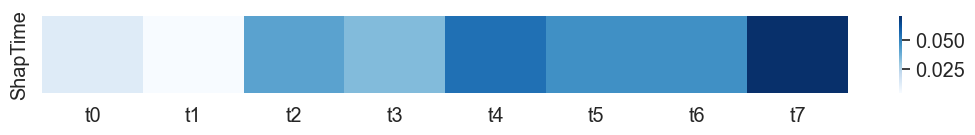

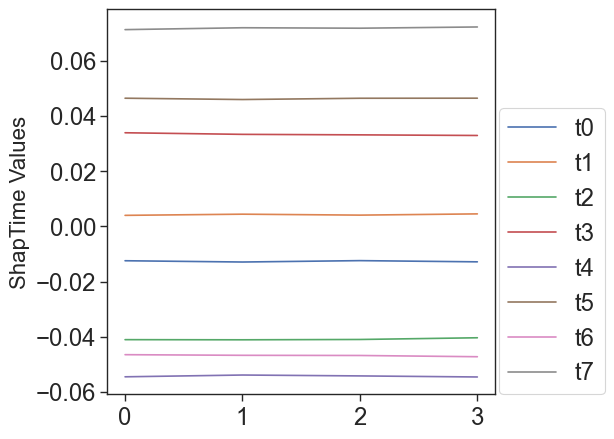

In [31]:
PlotVal(result)

### Sensitivity

In [32]:
situation_0 = [0, 1, 2, 3, 4, 5, 6, 7]
situation_1 = [0, 1, 2, 3, 4, 5, 6, 1]
situation_2 = [0, 1, 2, 3, 0, 5, 6, 1]

In [33]:
total = [situation_0, situation_1, situation_2]
train_eva = train.drop(columns = 'date')

IRS_train_eva = IRS_train.drop(columns = 'date')

df_eva = supertime(8, train_eva)

IRS_df_eva = supertime(8, IRS_train_eva)

model_eva = lgb.LGBMRegressor()

IRS_model_eva = lgb.LGBMRegressor()

In [34]:
import EvaluationBoosting
from EvaluationBoosting import evaluation, R2Plot, MSEPlot

In [35]:
r2_results, mse_results = evaluation(df_eva, x_train, y_train, 'meantemp', model_eva, total)

IRS_r2_results, IRS_mse_results = evaluation(IRS_df_eva, IRS_x_train, IRS_y_train, 'meantemp', IRS_model_eva, total)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 814
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 7
[LightGBM] [Info] Start training from score 0.604416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 7
[LightGBM] [Info] Start training from score 0.581498
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 814
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 7
[LightGBM] [Info] Start training fro

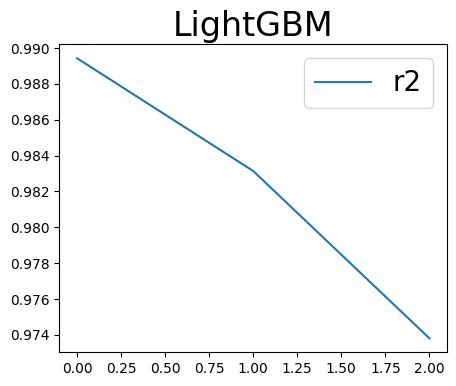

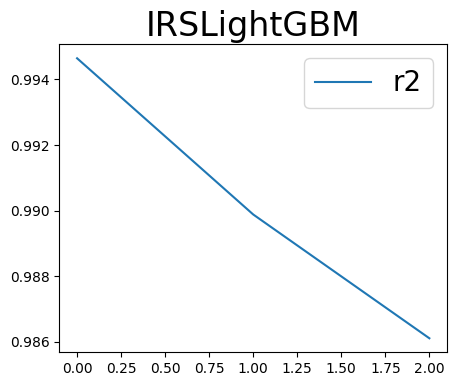

In [36]:
R2Plot(r2_results, 'LightGBM')

R2Plot(IRS_r2_results, 'IRSLightGBM')


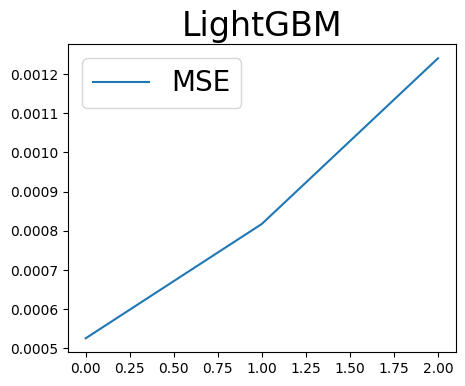

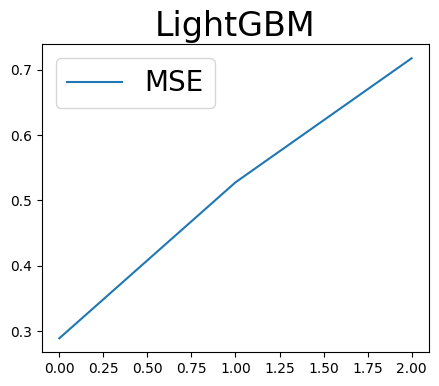

In [37]:
MSEPlot(mse_results, 'LightGBM')

MSEPlot(IRS_mse_results, "LightGBM")

# Improvement

In [38]:
for k in range(Tn):
    exec(f't{k} = supertime(Tn, train)[k]')

In [39]:
check_replist = [t0, t1, t2, t3, t4, t5, t6, t7]

In [40]:
t4

,date,meantemp,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
699,2014-12-01,0.427948,0.345228,0.208432,0.132354,0.25,1.000000,0.000000,0.000000
700,2014-12-02,0.469978,0.404350,0.186523,0.132224,0.25,1.000000,0.033333,0.166667
701,2014-12-03,0.580786,0.628378,0.269337,0.131475,0.25,1.000000,0.066667,0.333333
702,2014-12-04,0.466157,0.655617,0.115171,0.131915,0.25,1.000000,0.100000,0.500000
703,2014-12-05,0.359170,0.549198,0.060398,0.132793,0.25,1.000000,0.133333,0.666667
...,...,...,...,...,...,...,...,...,...
868,2015-05-19,0.779476,0.361486,0.350841,0.130841,0.50,0.363636,0.600000,0.166667
869,2015-05-20,0.829148,0.215160,0.345808,0.130824,0.50,0.363636,0.633333,0.333333
870,2015-05-21,0.905568,0.132390,0.268534,0.130613,0.50,0.363636,0.666667,0.500000
871,2015-05-22,0.924672,0.071791,0.296364,0.130320,0.50,0.363636,0.700000,0.666667


In [41]:
t1

,date,meantemp,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
177,2013-06-27,0.777293,0.572635,0.188469,0.130136,0.0,0.454545,0.866667,0.500000
178,2013-06-28,0.779476,0.600929,0.208728,0.130043,0.0,0.454545,0.900000,0.666667
179,2013-06-29,0.832969,0.515203,0.328636,0.129946,0.0,0.454545,0.933333,0.833333
180,2013-06-30,0.820233,0.458052,0.248697,0.130195,0.0,0.454545,0.966667,1.000000
181,2013-07-01,0.851528,0.479730,0.206740,0.130099,0.0,0.545455,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
346,2013-12-13,0.340611,0.641892,0.275428,0.132126,0.0,1.000000,0.400000,0.666667
347,2013-12-14,0.310044,0.775338,0.018948,0.132200,0.0,1.000000,0.433333,0.833333
348,2013-12-15,0.290393,0.861064,0.060398,0.132533,0.0,1.000000,0.466667,1.000000
349,2013-12-16,0.282751,0.899493,0.027534,0.132598,0.0,1.000000,0.500000,0.000000


In [42]:
IRS_data[IRS_data['t_7'] == 1]

,Unnamed_0,date,meantemp,humidity,wind_speed,meanpressure,month,year,sin_dayofyear,cos_dayofyear,...,meantemp_roll_mean_7d,meantemp_roll_mean_30d,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7
1378,1378,2016-10-10,29.777778,51.111111,4.807407,1006.148148,10,2016,-0.986731,0.162366,...,30.834546,31.642701,0,0,0,0,0,0,0,1
1379,1379,2016-10-11,29.666667,51.148148,8.922222,1006.592593,10,2016,-0.983798,0.179281,...,30.335767,31.594268,0,0,0,0,0,0,0,1
1380,1380,2016-10-12,29.571429,47.285714,11.371429,1006.250000,10,2016,-0.980575,0.196143,...,30.208783,31.549824,0,0,0,0,0,0,0,1
1381,1381,2016-10-13,29.962963,44.000000,13.022222,1008.333333,10,2016,-0.977064,0.212947,...,30.314225,31.480776,0,0,0,0,0,0,0,1
1382,1382,2016-10-14,29.750000,47.875000,8.934783,1009.125000,10,2016,-0.973264,0.229688,...,30.208405,31.395097,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570,1570,2017-04-20,34.500000,27.500000,5.562500,998.625000,4,2017,0.949990,-0.312281,...,31.777778,29.554306,0,0,0,0,0,0,0,1
1571,1571,2017-04-21,34.250000,39.375000,6.962500,999.875000,4,2017,0.944489,-0.328542,...,32.468254,29.870973,0,0,0,0,0,0,0,1
1572,1572,2017-04-22,32.900000,40.900000,8.890000,1001.600000,4,2017,0.938710,-0.344707,...,33.003968,30.104306,0,0,0,0,0,0,0,1
1573,1573,2017-04-23,32.875000,27.500000,9.962500,1002.125000,4,2017,0.932655,-0.360771,...,33.243651,30.267639,0,0,0,0,0,0,0,1


In [43]:
# IRS_x_test
s = pd.concat(check_replist, axis = 0)


In [44]:
s

,date,meantemp,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
3,2013-01-04,0.081514,0.684685,0.029212,0.132799,0.00,0.000000,0.100000,0.666667
4,2013-01-05,0.000000,0.867962,0.087636,0.132712,0.00,0.000000,0.133333,0.833333
5,2013-01-06,0.030568,0.820270,0.035054,0.132907,0.00,0.000000,0.166667,1.000000
6,2013-01-07,0.030568,0.770608,0.149218,0.133167,0.00,0.000000,0.200000,0.000000
7,2013-01-08,0.087336,0.594595,0.169182,0.133000,0.00,0.000000,0.233333,0.166667
...,...,...,...,...,...,...,...,...,...
1390,2016-10-22,0.713246,0.426301,0.315563,0.131784,0.75,0.818182,0.700000,0.833333
1391,2016-10-23,0.657205,0.491099,0.273476,0.131776,0.75,0.818182,0.733333,1.000000
1392,2016-10-24,0.687773,0.449259,0.265004,0.131640,0.75,0.818182,0.766667,0.000000
1393,2016-10-25,0.673712,0.486351,0.293426,0.131726,0.75,0.818182,0.800000,0.166667


In [45]:
IRS_x_train

,Unnamed_0,humidity,wind_speed,meanpressure,month,year,sin_dayofyear,cos_dayofyear,meantemp_lag_1,meantemp_roll_mean_7d,meantemp_roll_mean_30d,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7
0,0,84.500000,0.000000,1015.666667,1,2013,0.017166,0.999853,NaN,NaN,NaN,1,0,0,0,0,0,0,0
1,1,92.000000,2.980000,1017.800000,1,2013,0.034328,0.999411,10.000000,10.000000,10.000000,1,0,0,0,0,0,0,0
2,2,87.000000,4.633333,1018.666667,1,2013,0.051479,0.998674,7.400000,8.700000,8.700000,1,0,0,0,0,0,0,0
3,3,71.333333,1.233333,1017.166667,1,2013,0.068615,0.997643,7.166667,8.188889,8.188889,1,0,0,0,0,0,0,0
4,4,86.833333,3.700000,1016.500000,1,2013,0.085731,0.996318,8.666667,8.308333,8.308333,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,1390,49.481481,13.323077,1009.370370,10,2016,-0.932655,0.360771,28.409091,28.525893,30.452087,0,0,0,0,0,0,0,1
1391,1391,54.961538,11.546154,1009.307692,10,2016,-0.926324,0.376728,29.333333,28.753406,30.428630,0,0,0,0,0,0,0,1
1392,1392,51.423077,11.188462,1008.269231,10,2016,-0.919720,0.392574,27.500000,28.620753,30.311963,0,0,0,0,0,0,0,1
1393,1393,54.560000,12.388462,1008.923077,10,2016,-0.912846,0.408304,28.500000,28.606468,30.220630,0,0,0,0,0,0,0,1


In [46]:
['t_'+str(i) for i in range(0,8)]

['t_0', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7']

In [47]:
# remove t7, replace with another copy of t6 

IRS_check = IRS_train[(IRS_train['t_6'] != 1) & (IRS_train['t_3'] != 1)]
IRS_check = pd.concat([IRS_check, IRS_train[IRS_train['t_2'] == 1]])


In [48]:
IRS_check

,Unnamed_0,date,meantemp,humidity,wind_speed,meanpressure,month,year,sin_dayofyear,cos_dayofyear,...,meantemp_roll_mean_7d,meantemp_roll_mean_30d,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7
0,0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,2013,0.017166,0.999853,...,NaN,NaN,1,0,0,0,0,0,0,0
1,1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,1,2013,0.034328,0.999411,...,10.000000,10.000000,1,0,0,0,0,0,0,0
2,2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,1,2013,0.051479,0.998674,...,8.700000,8.700000,1,0,0,0,0,0,0,0
3,3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,1,2013,0.068615,0.997643,...,8.188889,8.188889,1,0,0,0,0,0,0,0
4,4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,1,2013,0.085731,0.996318,...,8.308333,8.308333,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,586,2014-08-10,28.500000,89.906250,5.225000,1002.156250,8,2014,-0.620609,-0.784120,...,30.747899,31.469153,0,0,1,0,0,0,0,0
587,587,2014-08-11,31.125000,72.125000,3.012500,999.875000,8,2014,-0.633978,-0.773351,...,30.319328,31.198319,0,0,1,0,0,0,0,0
588,588,2014-08-12,32.125000,57.500000,8.337500,998.750000,8,2014,-0.647161,-0.762354,...,30.408613,31.039986,0,0,1,0,0,0,0,0
589,589,2014-08-13,32.125000,57.714286,20.825000,998.250000,8,2014,-0.660152,-0.751132,...,30.747899,31.056653,0,0,1,0,0,0,0,0


In [49]:
IRS_check = IRS_check.drop(['t_0', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7'],axis=1)
IRS_check.drop('Unnamed_0', inplace=True,axis=1)

In [50]:
IRS_check

,date,meantemp,humidity,wind_speed,meanpressure,month,year,sin_dayofyear,cos_dayofyear,meantemp_lag_1,meantemp_roll_mean_7d,meantemp_roll_mean_30d
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,2013,0.017166,0.999853,NaN,NaN,NaN
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,1,2013,0.034328,0.999411,10.000000,10.000000,10.000000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,1,2013,0.051479,0.998674,7.400000,8.700000,8.700000
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,1,2013,0.068615,0.997643,7.166667,8.188889,8.188889
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,1,2013,0.085731,0.996318,8.666667,8.308333,8.308333
...,...,...,...,...,...,...,...,...,...,...,...,...
586,2014-08-10,28.500000,89.906250,5.225000,1002.156250,8,2014,-0.620609,-0.784120,29.235294,30.747899,31.469153
587,2014-08-11,31.125000,72.125000,3.012500,999.875000,8,2014,-0.633978,-0.773351,28.500000,30.319328,31.198319
588,2014-08-12,32.125000,57.500000,8.337500,998.750000,8,2014,-0.647161,-0.762354,31.125000,30.408613,31.039986
589,2014-08-13,32.125000,57.714286,20.825000,998.250000,8,2014,-0.660152,-0.751132,32.125000,30.747899,31.056653


In [51]:
IRS_y_train

,meantemp
0,10.000000
1,7.400000
2,7.166667
3,8.666667
4,6.000000
...,...
1390,29.333333
1391,27.500000
1392,28.500000
1393,28.040000


In [57]:
IRS_x_test.drop(['t_0', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7'],axis=1, inplace=True)

In [60]:
IRS_x_test.drop(['Unnamed_0'],axis=1, inplace=True)

In [59]:
IRS_x_test

,Unnamed_0,humidity,wind_speed,meanpressure,month,year,sin_dayofyear,cos_dayofyear,meantemp_lag_1,meantemp_roll_mean_7d,meantemp_roll_mean_30d
1395,1395,59.370370,6.044444,1014.629630,10,2016,-0.898292,0.439400,27.576923,28.348039,29.987513
1396,1396,58.777778,7.277778,1012.407407,10,2016,-0.890617,0.454755,26.555556,27.987843,29.799859
1397,1397,62.777778,1.714815,1013.000000,10,2016,-0.882679,0.469977,25.518519,27.574904,29.569143
1398,1398,71.043478,2.013043,1014.608696,10,2016,-0.874481,0.485060,25.814815,27.072259,29.355394
1399,1399,66.807692,1.642308,1017.807692,10,2016,-0.866025,0.500000,24.826087,26.690271,29.109121
...,...,...,...,...,...,...,...,...,...,...,...
1570,1570,27.500000,5.562500,998.625000,4,2017,0.949990,-0.312281,33.500000,31.777778,29.554306
1571,1571,39.375000,6.962500,999.875000,4,2017,0.944489,-0.328542,34.500000,32.468254,29.870973
1572,1572,40.900000,8.890000,1001.600000,4,2017,0.938710,-0.344707,34.250000,33.003968,30.104306
1573,1573,27.500000,9.962500,1002.125000,4,2017,0.932655,-0.360771,32.900000,33.243651,30.267639


In [61]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'date','meantemp'}, axis = 1)
y_check = check.loc[:, ['meantemp']]

IRS_x_check = IRS_check.drop(['meantemp','date'],axis=1)
IRS_y_check = IRS_check[['meantemp']]

model_check = lgb.LGBMRegressor().fit(x_check, y_check)
# ours
IRS_model_check = lgb.LGBMRegressor().fit(IRS_x_check, IRS_y_check)


pred_check = model_check.predict(x_test)
IRS_pred_check = IRS_model_check.predict(IRS_x_test)

r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)
# ours 
IRS_r2_check = r2_score(IRS_pred_check, IRS_y_test)
IRS_mse_check = mean_squared_error(IRS_pred_check, IRS_y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

print(IRS_r2_check, 'IRS Degree of Improvement: {:.2%}'.format((IRS_r2_check-IRS_r2)/abs(IRS_r2)))
print(IRS_mse_check, 'IRS Degree of Improvement: {:.2%}'.format((IRS_mse-IRS_mse_check)/IRS_mse))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 814
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 7
[LightGBM] [Info] Start training from score 0.604416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 1198, number of used features: 10
[LightGBM] [Info] Start training from score 25.642822
0.7811098680074982 Degree of Improvement: -0.04%
0.008214173339803442 Degree of Improvement: 0.69%
0.9158979325153723 IRS Degree of Improvement: -1.12%
2.428028844781072 IRS Degree of Improvement: -7.63%


In [ ]:
# #check
# check = pd.concat(check_replist, axis = 0)
# x_check = check.drop(columns = {'date','meantemp'}, axis = 1)
# y_check = check.loc[:, ['meantemp']]

# IRS_check = check
# IRS_x_check = x_check
# IRS_y_check = y_check

# model_check = lgb.LGBMRegressor().fit(x_check, y_check)
# # ours
# IRS_model_check = lgb.LGBMRegressor().fit(IRS_x_check, IRS_y_check)


# pred_check = model_check.predict(x_test)
# IRS_pred_check = IRS_model_check.predict(IRS_x_test)

# r2_check = r2_score(pred_check, y_test)
# mse_check = mean_squared_error(pred_check, y_test)
# # ours 
# IRS_r2_check = r2_score(IRS_pred_check, IRS_y_test)
# IRS_mse_check = mean_squared_error(IRS_pred_check, IRS_y_test)

# print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
# print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

# print(IRS_r2_check, 'IRS Degree of Improvement: {:.2%}'.format((IRS_r2_check-IRS_r2)/abs(IRS_r2)))
# print(IRS_mse_check, 'IRS Degree of Improvement: {:.2%}'.format((IRS_mse-IRS_mse_check)/IRS_mse))

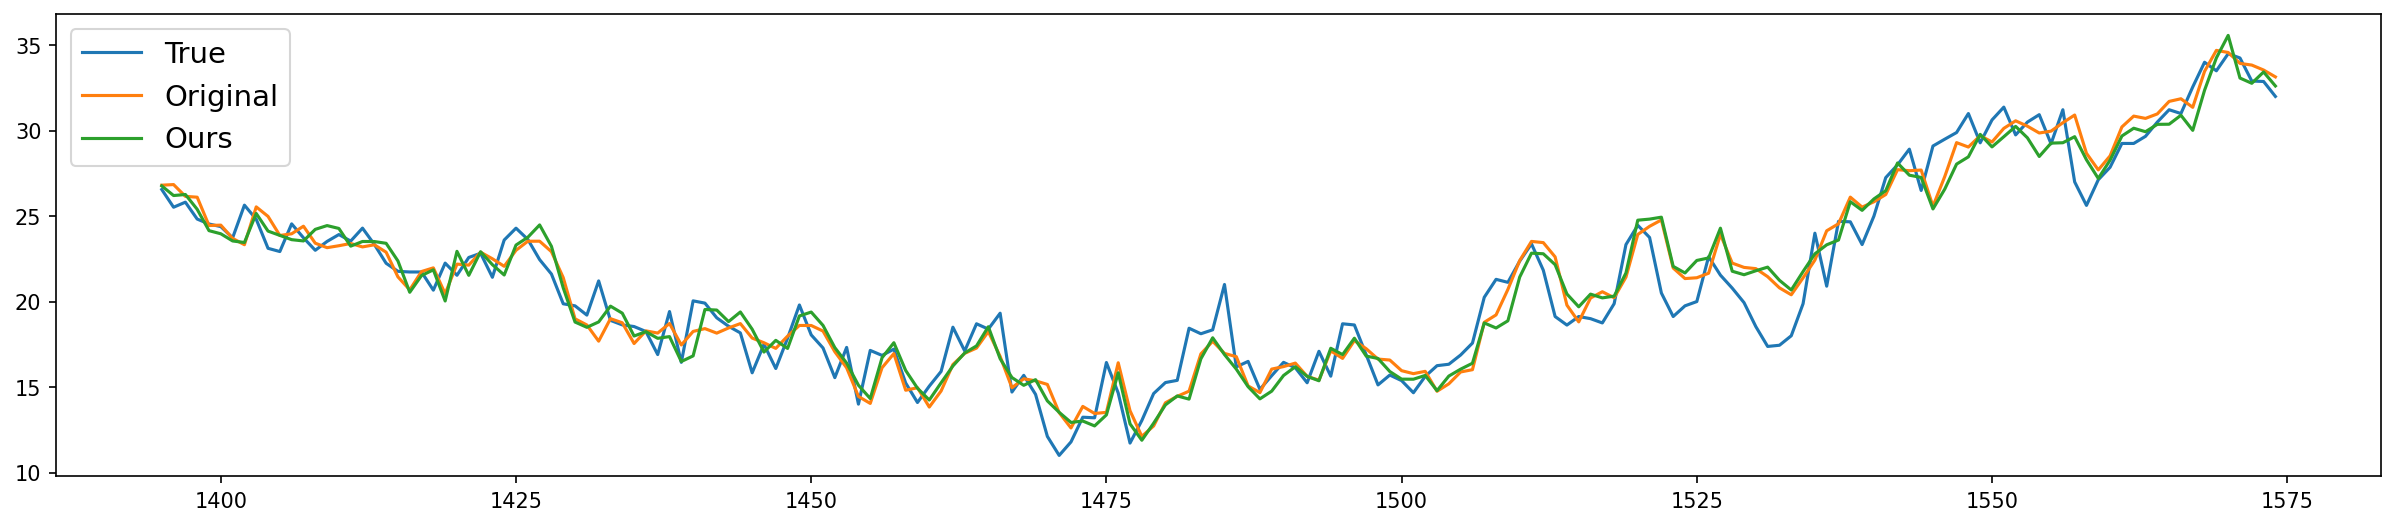

In [62]:
# our plot 

IRS_pred_our = pd.DataFrame(IRS_pred_check, index=IRS_y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(IRS_y_test['meantemp'], label = 'True')
plt.plot(IRS_prediction, label = 'Original')
plt.plot(IRS_pred_our, label = 'Ours')

plt.legend(fontsize = 14)
plt.show()

# wee replace orange one just w our data

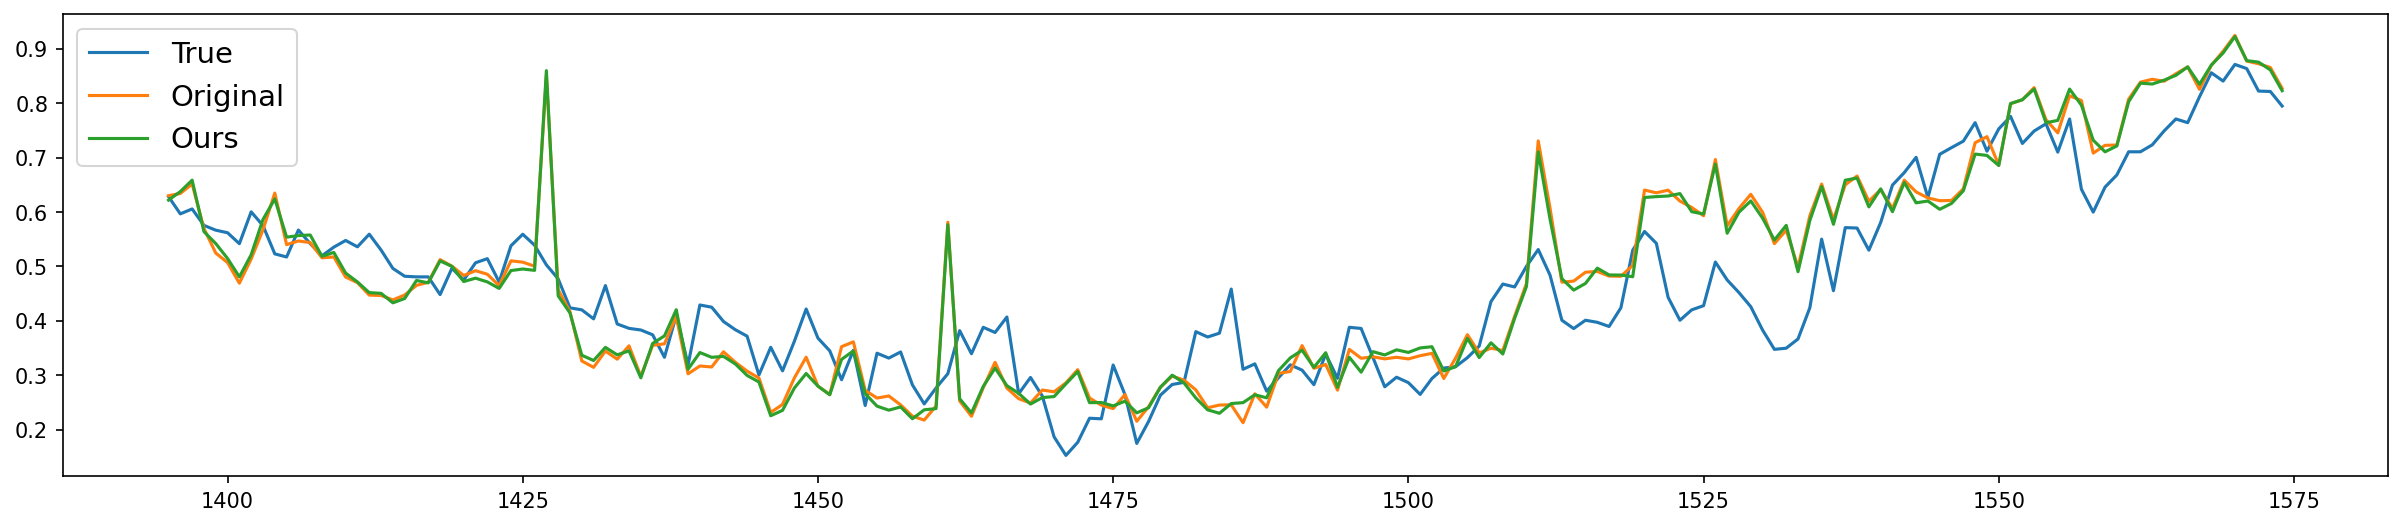

In [ ]:
pred_our = pd.DataFrame(pred_check, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['meantemp'], label = 'True')
plt.plot(prediction, label = 'Original')
plt.plot(pred_our, label = 'Ours')

plt.legend(fontsize = 14)
plt.show()

# wee replace orange one just w our data

# Time-Enhanced Dataset Analysis

Applying the complete ShapTime methodology to the time-enhanced dataset with rich temporal features.

In [ ]:
# Load time-enhanced dataset
data_enhanced = pd.read_csv('../../Data/Processed/time_features.csv')
data_enhanced.head()

,Unnamed: 0,date,meantemp,humidity,wind_speed,meanpressure,month,year,sin_dayofyear,cos_dayofyear,...,meantemp_roll_mean_7d,meantemp_roll_mean_30d,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7
0,0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,2013,0.017166,0.999853,...,NaN,NaN,1,0,0,0,0,0,0,0
1,1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,1,2013,0.034328,0.999411,...,10.000000,10.000000,1,0,0,0,0,0,0,0
2,2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,1,2013,0.051479,0.998674,...,8.700000,8.700000,1,0,0,0,0,0,0,0
3,3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,1,2013,0.068615,0.997643,...,8.188889,8.188889,1,0,0,0,0,0,0,0
4,4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,1,2013,0.085731,0.996318,...,8.308333,8.308333,1,0,0,0,0,0,0,0


In [ ]:
# Data split for time-enhanced dataset
train_enhanced = data_enhanced[:-180]
test_enhanced = data_enhanced[-180:]
print("Enhanced train shape:", train_enhanced.shape)
print("Enhanced test shape:", test_enhanced.shape)

Enhanced train shape: (1395, 21)
Enhanced test shape: (180, 21)


In [ ]:
# Prepare features for time-enhanced model (handle NaN values)
# Drop date column and fill any NaN values
train_clean = train_enhanced.drop(columns=['date']).fillna(method='ffill').fillna(method='bfill')
test_clean = test_enhanced.drop(columns=['date']).fillna(method='ffill').fillna(method='bfill')

x_train_enh = train_clean.drop(columns={'meantemp'}, axis=1)
y_train_enh = train_clean.loc[:, ['meantemp']]

x_test_enh = test_clean.drop(columns={'meantemp'}, axis=1)
y_test_enh = test_clean.loc[:, ['meantemp']]

print("Enhanced features:", x_train_enh.columns.tolist())

Enhanced features: ['Unnamed: 0', 'humidity', 'wind_speed', 'meanpressure', 'month', 'year', 'sin_dayofyear', 'cos_dayofyear', 'meantemp_lag_1', 'meantemp_roll_mean_7d', 'meantemp_roll_mean_30d', 't_0', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7']


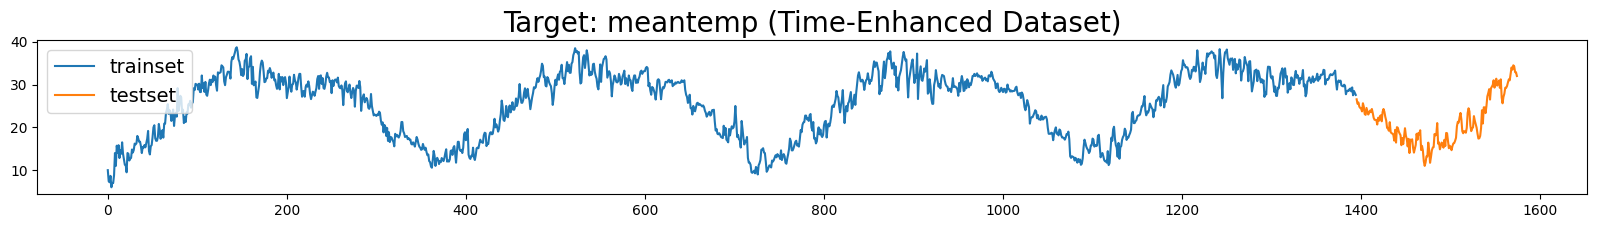

In [ ]:
# Visualize enhanced dataset
sns.reset_orig()
plt.figure(figsize = (20,2))
plt.title('Target: meantemp (Time-Enhanced Dataset)', fontsize = 20)
plt.plot(y_train_enh['meantemp'], label = 'trainset')
plt.plot(y_test_enh['meantemp'], label = 'testset')

plt.legend(fontsize = 14)
plt.show()

# LightGBM on Time-Enhanced Dataset

In [ ]:
# Train LightGBM on enhanced features
model_enh = lgb.LGBMRegressor().fit(x_train_enh, y_train_enh)

pred_enh = model_enh.predict(x_test_enh)
r2_enh = r2_score(pred_enh, y_test_enh)
mse_enh = mean_squared_error(pred_enh, y_test_enh)

print('Enhanced Dataset - R2: ', r2_enh, '  ;  ', 'MSE: ', mse_enh)

[LightGBM] [Fatal] Do not support special JSON characters in feature name.


LightGBMError: Do not support special JSON characters in feature name.

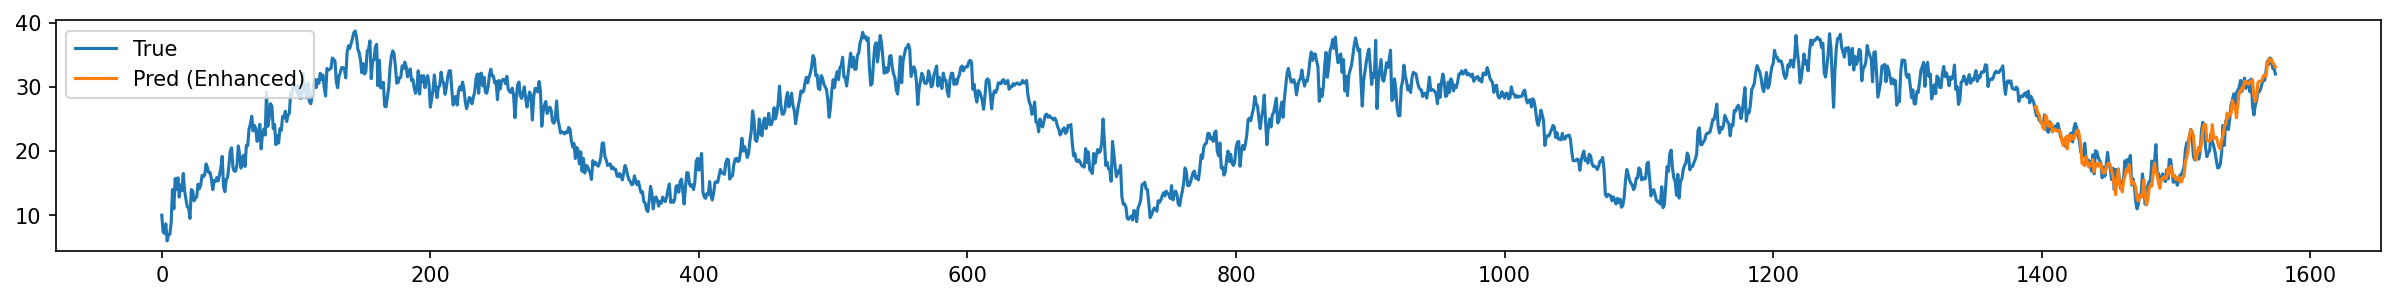

In [ ]:
# Visualize enhanced model predictions
prediction_enh = pd.DataFrame(pred_enh, index=y_test_enh.index)

sns.reset_orig()
plt.figure(figsize = (20,2), dpi=150)

plt.plot(data_enhanced['meantemp'], label = 'True')
plt.plot(prediction_enh, label = 'Pred (Enhanced)')

plt.legend()
plt.show()

# Interpretation of Enhanced LightGBM

In [ ]:
# ShapTime analysis on enhanced dataset
Tn_enh = 8
interp_x_enh = x_train_enh
model_enh = model_enh

ShapTime_lgb_enh = ShapleyValues(model_enh, interp_x_enh, Tn_enh)

In [ ]:
ShapTime_lgb_enh

[np.float64(-0.41151755675599094),
 np.float64(0.13530815275347716),
 np.float64(-1.3335645429203784),
 np.float64(1.1150716283047382),
 np.float64(-1.7972241920260026),
 np.float64(1.5227408443379706),
 np.float64(-1.5365014250277267),
 np.float64(2.343392844201583)]

In [ ]:
# Time period names for enhanced dataset
time_columns_enh = ['t', 't1_enh', 't2_enh', 't3_enh', 't4_enh', 't5_enh', 't6_enh', 't7_enh']

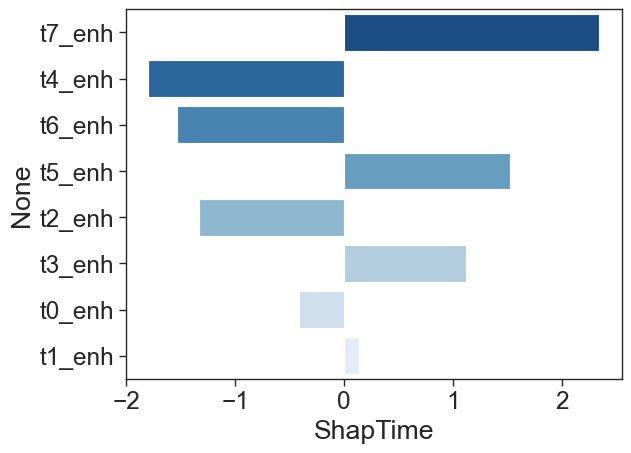

In [ ]:
TimeImportance(Tn_enh, ShapTime_lgb_enh, time_columns_enh)

In [ ]:
TimeHeatmap(Tn_enh, ShapTime_lgb_enh, time_columns_enh)

In [ ]:
for k in range(Tn):
    exec(f't{k} = supertime(Tn, train)[k]')

In [ ]:
check_replist = [t0, t7, t2, t3, t4, t5, t6, t7]

In [ ]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'date','meantemp'}, axis = 1)
y_check = check.loc[:, ['meantemp']]

model_check = lgb.LGBMRegressor().fit(x_check, y_check)

pred_check = model_check.predict(x_test)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

In [ ]:
pred_our = pd.DataFrame(pred_check, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['meantemp'], label = 'True')
plt.plot(prediction, label = 'Original')
plt.plot(pred_our, label = 'Ours')

plt.legend(fontsize = 14)
plt.show()

# Evaluation of Enhanced Dataset Interpretation

### Feature-Independence (Enhanced)

In [ ]:
# Feature independence evaluation for enhanced dataset
n_enh = 3
Tn_enh = 8
x_train_val_enh = x_train_enh.copy()
y_train_enh_val = y_train_enh
initial_enh = ShapTime_lgb_enh
model_enh_val = lgb.LGBMRegressor()

In [ ]:
result_enh = FeaIndepenVal(x_train_val_enh, y_train_enh_val, initial_enh, model_enh_val, Tn_enh, n_enh, time_columns_enh)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 9
[LightGBM] [Info] Start training from score 25.735216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 8
[LightGBM] [Info] Start training from score 25.735216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 8
[LightGBM] [Info] Start trainin

In [ ]:
result_enh

,t0_enh,t1_enh,t2_enh,t3_enh,t4_enh,t5_enh,t6_enh,t7_enh
0,-0.411518,0.135308,-1.333565,1.115072,-1.797224,1.522741,-1.536501,2.343393
1,-0.406052,0.142221,-1.328016,1.087974,-1.778994,1.518704,-1.547374,2.348949
2,-0.401758,0.141382,-1.334239,1.090171,-1.780583,1.520285,-1.545574,2.347534
3,-0.416581,0.145524,-1.326418,1.088221,-1.784073,1.523188,-1.542141,2.349257


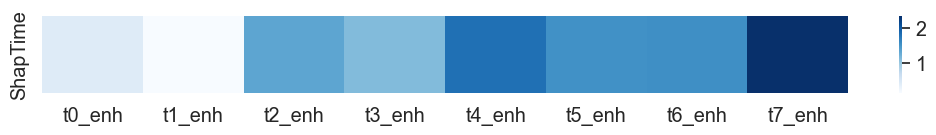

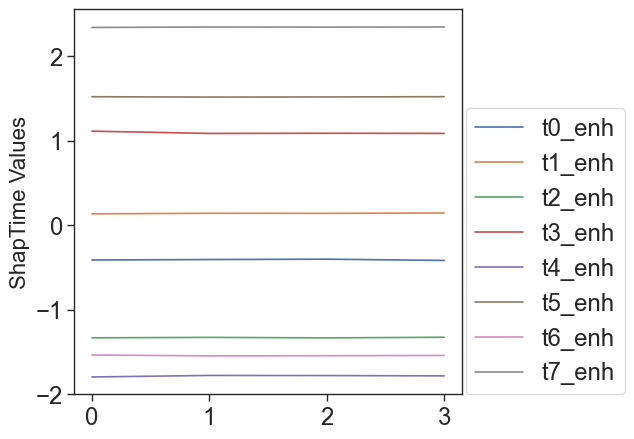

In [ ]:
PlotVal(result_enh)

### Sensitivity (Enhanced)

In [ ]:
# Sensitivity analysis for enhanced dataset
situation_0_enh = [0, 1, 2, 3, 4, 5, 6, 7]
situation_1_enh = [0, 1, 2, 3, 4, 5, 6, 1]
situation_2_enh = [0, 1, 2, 3, 0, 5, 6, 1]

In [ ]:
total_enh = [situation_0_enh, situation_1_enh, situation_2_enh]
train_eva_enh = train_clean
df_eva_enh = supertime(8, train_eva_enh)
model_eva_enh = lgb.LGBMRegressor()

In [ ]:
r2_results_enh, mse_results_enh = evaluation(df_eva_enh, x_train_enh, y_train_enh, 'meantemp', model_eva_enh, total_enh)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2033
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 10
[LightGBM] [Info] Start training from score 25.773032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2039
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 10
[LightGBM] [Info] Start training from score 25.023301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2039
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 10
[LightGBM] [Info] Start trai

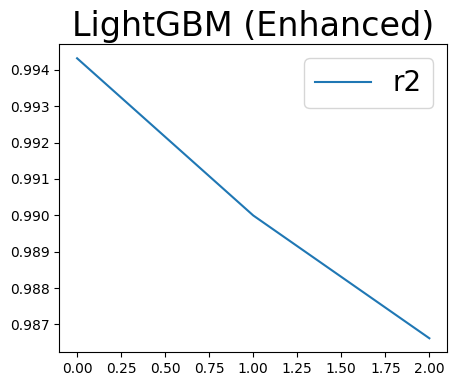

In [ ]:
R2Plot(r2_results_enh, 'LightGBM (Enhanced)')

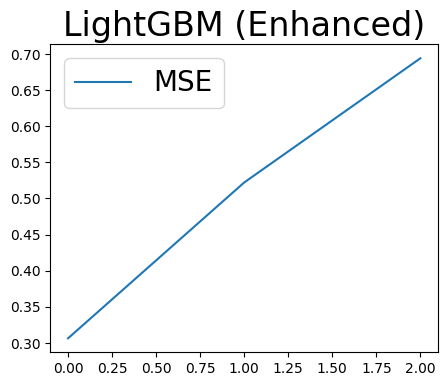

In [ ]:
MSEPlot(mse_results_enh, 'LightGBM (Enhanced)')

# Improvement (Enhanced Dataset)

In [ ]:
# Generate time periods for enhanced dataset
for k in range(Tn_enh):
    exec(f't{k}_enh = supertime(Tn_enh, train_clean)[k]')

In [ ]:
# Create improved model based on ShapTime insights for enhanced dataset
# Use the most important time periods identified by ShapTime
check_replist_enh = [t0_enh, t7_enh, t2_enh, t3_enh, t4_enh, t5_enh, t6_enh, t7_enh]

In [ ]:
# Train improved model on enhanced dataset
check_enh = pd.concat(check_replist_enh, axis = 0)
x_check_enh = check_enh.drop(columns = {'meantemp'}, axis = 1)
y_check_enh = check_enh.loc[:, ['meantemp']]

model_check_enh = lgb.LGBMRegressor().fit(x_check_enh, y_check_enh)

pred_check_enh = model_check_enh.predict(x_test_enh)
r2_check_enh = r2_score(pred_check_enh, y_test_enh)
mse_check_enh = mean_squared_error(pred_check_enh, y_test_enh)

print("Enhanced Dataset Results:")
print(r2_check_enh, 'Degree of Improvement: {:.2%}'.format((r2_check_enh-r2_enh)/abs(r2_enh)))
print(mse_check_enh, 'Degree of Improvement: {:.2%}'.format((mse_enh-mse_check_enh)/mse_enh))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2024
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 10
[LightGBM] [Info] Start training from score 26.522762
Enhanced Dataset Results:
0.9266222217545278 Degree of Improvement: -0.19%
2.3462752568295064 Degree of Improvement: -2.19%
Enhanced Dataset Results:
0.9266222217545278 Degree of Improvement: -0.19%
2.3462752568295064 Degree of Improvement: -2.19%


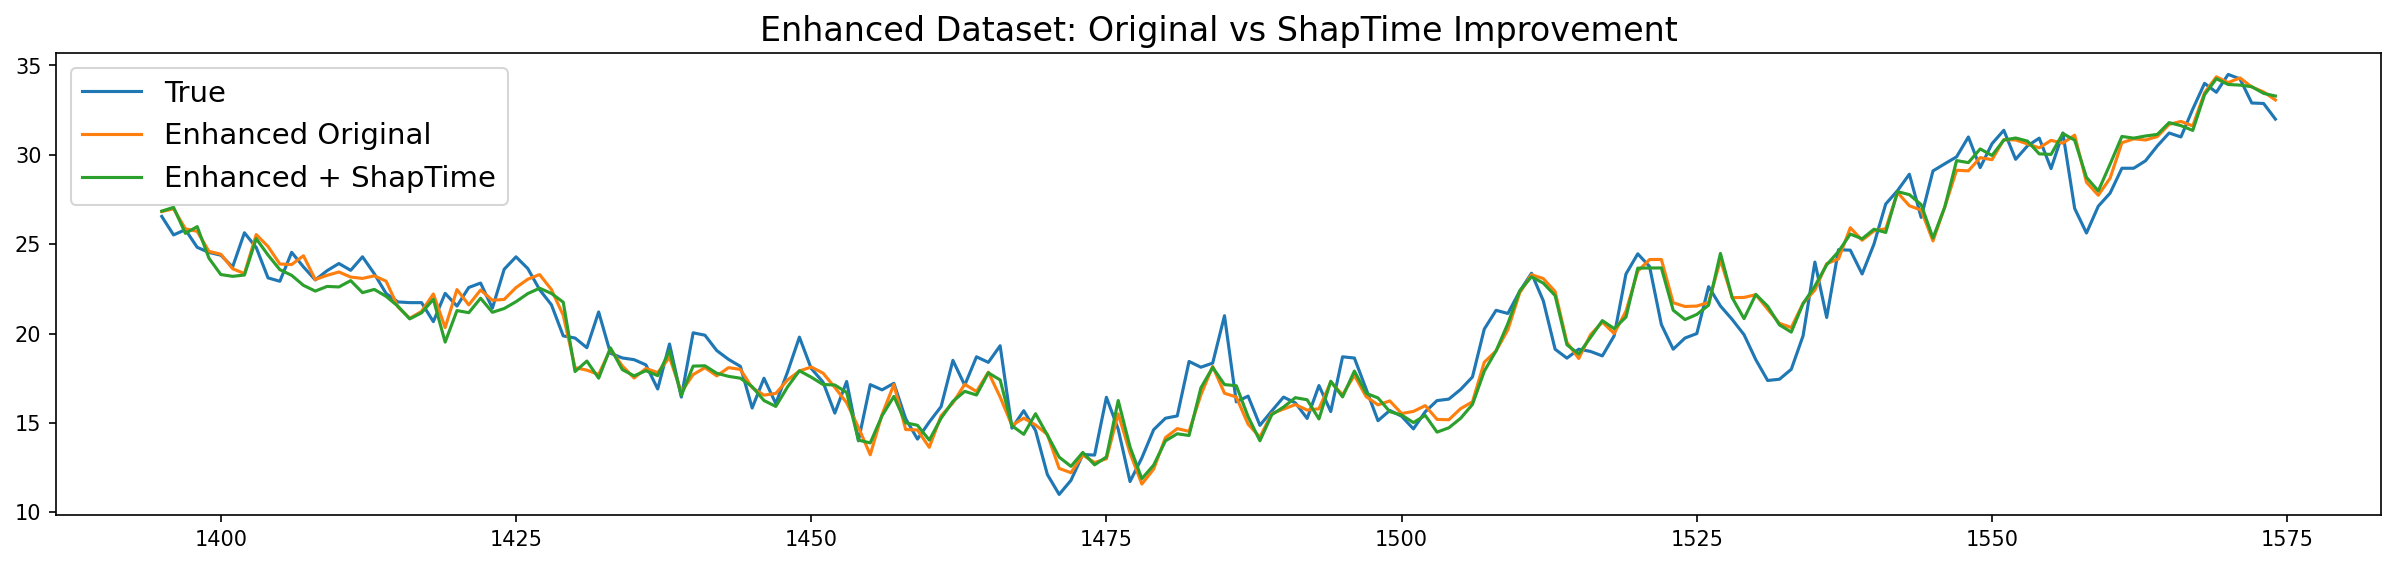

In [ ]:
# Final comparison: Enhanced dataset results
pred_our_enh = pd.DataFrame(pred_check_enh, index=y_test_enh.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test_enh['meantemp'], label = 'True')
plt.plot(prediction_enh, label = 'Enhanced Original')
plt.plot(pred_our_enh, label = 'Enhanced + ShapTime')

plt.title('Enhanced Dataset: Original vs ShapTime Improvement', fontsize=16)
plt.legend(fontsize = 14)
plt.show()

# Final Comparison: All Models

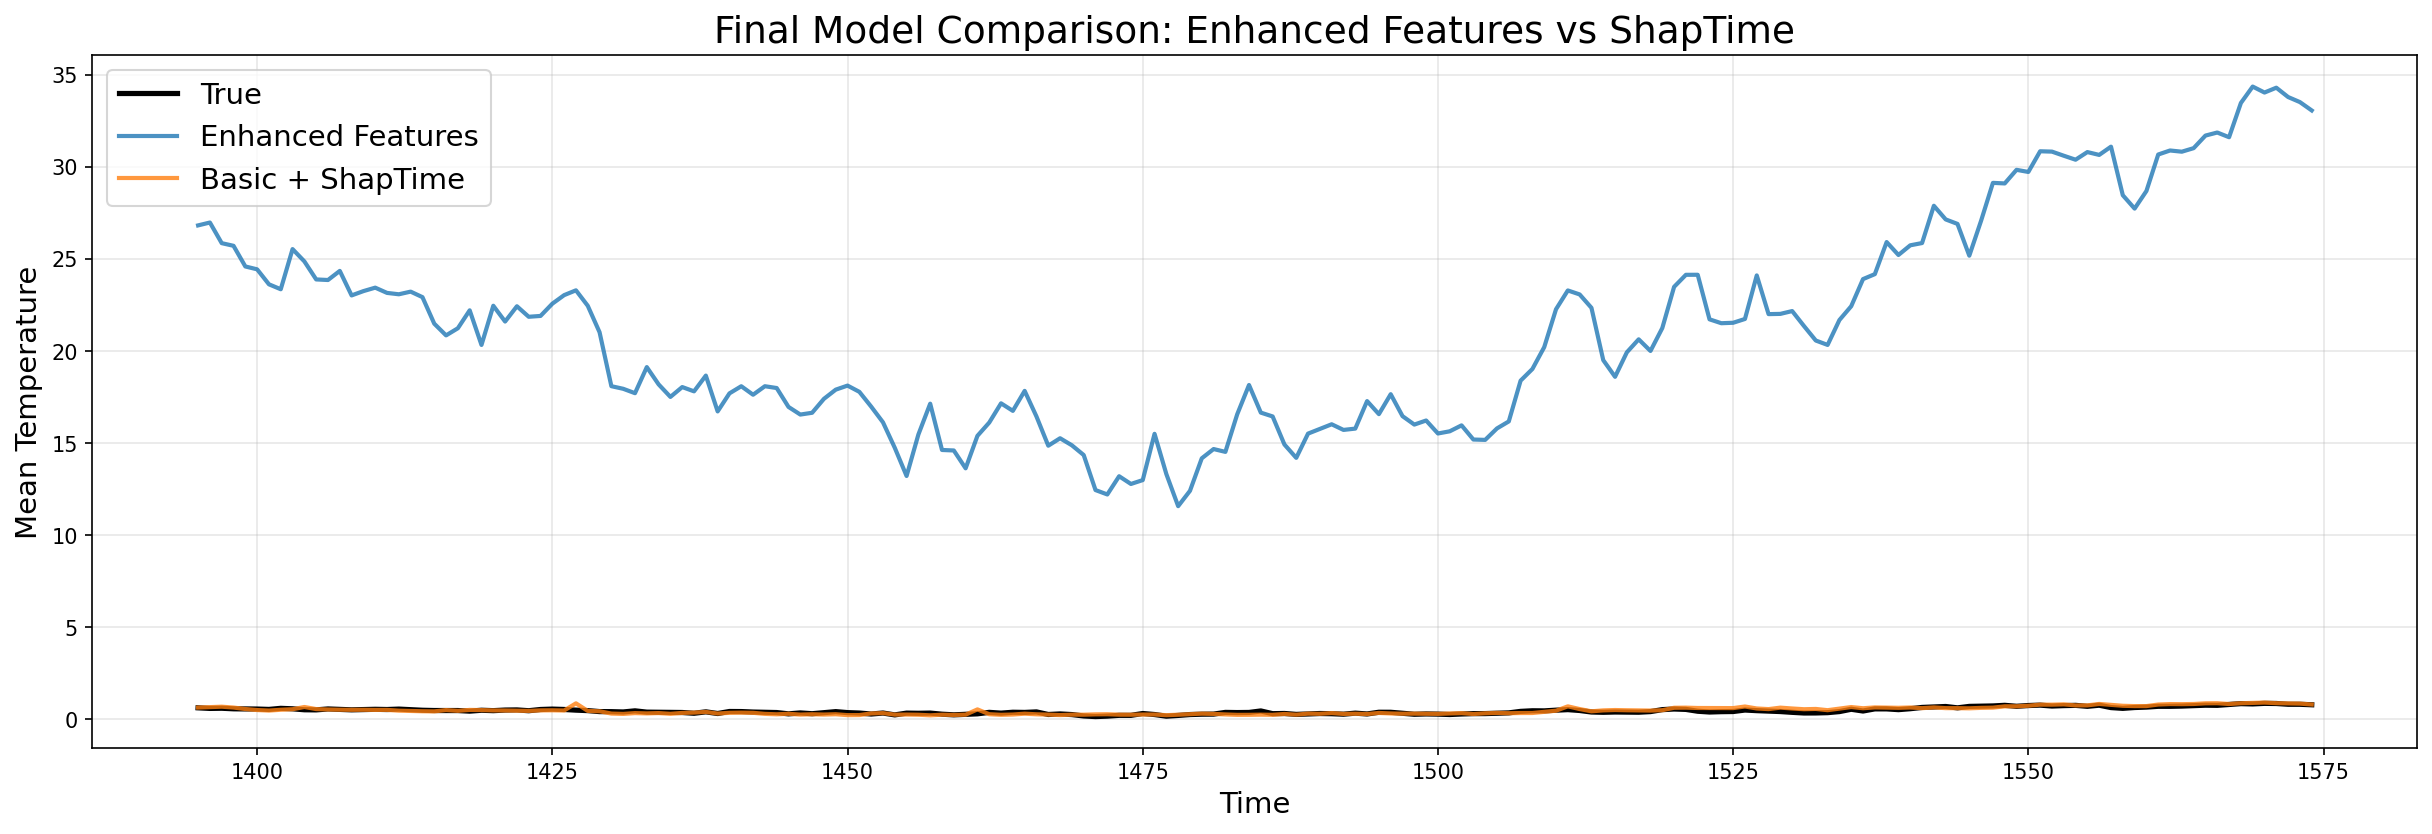

FINAL MODEL PERFORMANCE SUMMARY
Basic Features:           R² = 0.7814,      MSE = 0.008271
Enhanced Features:        R² = 0.9283,   MSE = 2.295934
Basic + ShapTime:         R² = 0.7848, MSE = 0.008233


In [ ]:
# Ultimate comparison plot replacing "Original" with "Enhanced Original"
sns.reset_orig()
plt.figure(figsize = (20,6), dpi=150)

plt.plot(y_test['meantemp'], label = 'True', linewidth=2.5, color='black')
plt.plot(prediction_enh, label = 'Enhanced Features', linewidth=2, alpha=0.8)  # This replaces "Original"
plt.plot(pred_our, label = 'Basic + ShapTime', linewidth=2, alpha=0.8)

plt.title('Final Model Comparison: Enhanced Features vs ShapTime', fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Mean Temperature', fontsize=14)
plt.legend(fontsize = 14, loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# Performance summary
print("="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Basic Features:           R² = {r2:.4f},      MSE = {mse:.6f}")
print(f"Enhanced Features:        R² = {r2_enh:.4f},   MSE = {mse_enh:.6f}")  
print(f"Basic + ShapTime:         R² = {r2_check:.4f}, MSE = {mse_check:.6f}")
print("="*60)